The goal of this project is to be able to classify users in the psychictxt application based on their usage. The data if from Sept 1 2015 - October 10 2015. The labels we are
going to user are:

Whale: For users who have asked and paid for more than 6 questions
High Roller: For users who have asked between 2-5 questions
Player: For users who have only asked 2 questions
Lapse: These are users who in previous months have asked more than 2 questions but during this time period only asked 1
Low Value: These are users who have not spent money in the app and only asked 1 question

The data was gathered together from a CSV as well as database calls to the google appengine DB so the first part below is just gathering and clearning data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import sys
import os
import getpass


AE_PATH = "/Program Files (x86)/Google/google_appengine/"
APP_PATH = os.path.abspath(".")
EXTRA_PATHS = [
    APP_PATH,
    AE_PATH,
    os.path.join(AE_PATH, 'lib', 'antlr3'),
    os.path.join(AE_PATH, 'lib', 'django'),
    os.path.join(AE_PATH, 'lib', 'ipaddr'),
    os.path.join(AE_PATH, 'lib', 'webob'),
    os.path.join(AE_PATH, 'lib', 'yaml', 'lib'),
    os.path.join(AE_PATH, 'lib', 'fancy_urllib'), # issue[1]
]
sys.path = EXTRA_PATHS + sys.path
from google.appengine.ext.remote_api import remote_api_stub

from google.appengine.api import users
from google.appengine.ext import db
from google.appengine.ext import webapp
from google.appengine.ext import ndb


In [2]:
!ls

bulkloader-log-20151006.172009
bulkloader-log-20151006.172028
bulkloader-progress-20151006.172028.sql3
bulkloader-results-20151006.172028.sql3
data_dump.csv
dataCleanded_removedNA_901-1010.csv
PsychicTxt_901-1010.csv
psychictxt_data_cleaned.ipynb
psychicTxt_data_reporting_901_1003.csv
psychictxt_project_part1.ipynb
PtxtSept16UserReporting.csv
README.md


In [3]:
!head -20 dataCleanded_removedNA_901-1010.csv

Base Reporting,,,,,,,,,,Active Advisor Counts - September/October,,,,,,,,,,
UserKey,User Name,Total Questions Sept/Oct,Total Questions,Average Answer,Avg Time Between Questions,First Contact,Recent Contact,Last Advisor,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive Advisors
"Key('DatastoreUserInfo', 'Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appspot.com')",Katie M.W.,526,544,01:50:26,00:01:56:18,08/21/15 16:22:06,10/10/15 21:46:30,Cynthia,High Value,112,2,306,#N/A,11,1,#N/A,2,92,#N/A,0
"Key('DatastoreUserInfo', 'EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appspot.com')",whitey,426,550,01:06:13,00:02:24:42,08/16/15 11:03:21,10/10/15 18:51:21,Amber,High Value,104,#N/A,284,26,12,#N/A,#N/A,#N/A,#N/A,#N/A,0
"Key('DatastoreUserInfo', 'iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appspot.com')",Charlene,412,412,02:53:49,00:01:51:30,09/10/15 13:51:44,10/10/15 09:38:06,Cynthia,High Value,#N/A,#N/A,412,#N/A,#N/A,#N/A,#N/A,#N/A,#N/A,#N/A,0
"Key('DatastoreUserInfo', 

In [4]:
#Here lets read the CSV into dataframe

psychicdata = pd.read_csv('dataCleanded_removedNA_901-1010.csv',header=1) 

In [5]:
psychicdata.tail()
# So the data here is the following:
# UserKey : ID of user
# UserName: probably not needed since it is not unique anyhow
# Total Questions Sept/Oct and Total Questions are the number of questions in this time period and total number of questions overall
# Average Answer is the time it took for a user to get a response to his/her question
# Avg time between questions is just that
# First Contact Recent Contact and Last Advisor will not be used
# UserValue is here but we will change it to what we want next
# Names of psychics is next along with how many questions they were asked

,UserKey,User Name,Total Questions Sept/Oct,Total Questions,Average Answer,Avg Time Between Questions,First Contact,Recent Contact,Last Advisor,UserValue,...,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive Advisors
5892,"Key('DatastoreUserInfo', 'sZjalFGmfo6WHKxFcrqb...",Dawn,1,1,00:05:03,NaN,10/10/15 23:33:37,10/10/15 23:33:37,Amber,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5893,"Key('DatastoreUserInfo', 'FrJz2YS16TFBxGehpx1g...",Emily,1,1,00:00:00,NaN,10/10/15 23:38:41,10/10/15 23:38:41,Desiree,Base,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0
5894,"Key('DatastoreUserInfo', '4mWh7SewAZptmnuEX78S...",Monica,1,1,00:00:00,NaN,10/10/15 23:40:29,10/10/15 23:40:29,Kitty,Base,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0
5895,"Key('DatastoreUserInfo', 'XPtvETDN8U3XawFAvI3h...",misty,1,1,00:10:27,NaN,10/10/15 23:41:43,10/10/15 23:41:43,David,Base,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0
5896,"Key('DatastoreUserInfo', 'Y5J3zEmzC0IYztVycx51...",Bree,1,1,00:00:00,NaN,10/10/15 23:59:54,10/10/15 23:59:54,Laurie,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0


In [6]:
psychicdata.isnull()

,UserKey,User Name,Total Questions Sept/Oct,Total Questions,Average Answer,Avg Time Between Questions,First Contact,Recent Contact,Last Advisor,UserValue,...,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive Advisors
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,True,True,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,True,True,True,True,True,True,True,False
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,True,True,True,True,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,True,True,True,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,True,True,False
6,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,True,True,True,True,False
8,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,True,True,False,False


In [7]:
# Looks like from above we have nulls where a user has not asked a psychic a question
# Lets make the columns look better and take out the whitespaces
newcolumns = []
for each in psychicdata.columns:
    newcolumns.append(each.replace(" ","_"))
psychicdata.columns = newcolumns
psychicdata.head()
psychicdata['OldPsychicQuestionsTotal']=0
psychicdata.head()

,UserKey,User_Name,Total_Questions_Sept/Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal
0,"Key('DatastoreUserInfo', 'Xk6vFJYnmjjgEJnWVcnV...",Katie M.W.,526,544,01:50:26,00:01:56:18,08/21/15 16:22:06,10/10/15 21:46:30,Cynthia,High Value,...,306,NaN,11,1,NaN,2,92,NaN,0,0
1,"Key('DatastoreUserInfo', 'EGS3omwhyDF2OxwiR490...",whitey,426,550,01:06:13,00:02:24:42,08/16/15 11:03:21,10/10/15 18:51:21,Amber,High Value,...,284,26,12,NaN,NaN,NaN,NaN,NaN,0,0
2,"Key('DatastoreUserInfo', 'iElbQBjtXBr4EUQQpazC...",Charlene,412,412,02:53:49,00:01:51:30,09/10/15 13:51:44,10/10/15 09:38:06,Cynthia,High Value,...,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,"Key('DatastoreUserInfo', 'fnOmv5FUMWVfr8OZIh9Z...",Becky,296,639,02:48:24,00:03:23:46,07/21/15 22:09:15,10/10/15 18:02:02,Gina,High Value,...,NaN,NaN,NaN,295,NaN,NaN,NaN,NaN,1,0
4,"Key('DatastoreUserInfo', 'bZ8tS8DOqFAVxLbmjzGZ...",Marie lethbridge,249,250,01:51:00,00:03:44:11,08/08/15 08:41:19,10/10/15 23:59:23,David,High Value,...,1,241,4,1,NaN,NaN,NaN,NaN,0,0


In [8]:
# Now we are going to convert the Average_Answer time to a particular score so it is easier to deal with
# the lower the score, the faster a response was given

psychicdata.First_Contact = pd.to_datetime(psychicdata.First_Contact)
TimeValues=[]
for each in psychicdata.Average_Answer:
    dt_obj = datetime.strptime(each, "%H:%M:%S")
    value = (dt_obj.hour * 3600) + (dt_obj.minute * 60) + dt_obj.second
    TimeValues.append(value)
psychicdata.Average_Answer = TimeValues
psychicdata.tail()

,UserKey,User_Name,Total_Questions_Sept/Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal
5892,"Key('DatastoreUserInfo', 'sZjalFGmfo6WHKxFcrqb...",Dawn,1,1,303,NaN,2015-10-10 23:33:37,10/10/15 23:33:37,Amber,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5893,"Key('DatastoreUserInfo', 'FrJz2YS16TFBxGehpx1g...",Emily,1,1,0,NaN,2015-10-10 23:38:41,10/10/15 23:38:41,Desiree,Base,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,0
5894,"Key('DatastoreUserInfo', '4mWh7SewAZptmnuEX78S...",Monica,1,1,0,NaN,2015-10-10 23:40:29,10/10/15 23:40:29,Kitty,Base,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0
5895,"Key('DatastoreUserInfo', 'XPtvETDN8U3XawFAvI3h...",misty,1,1,627,NaN,2015-10-10 23:41:43,10/10/15 23:41:43,David,Base,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5896,"Key('DatastoreUserInfo', 'Y5J3zEmzC0IYztVycx51...",Bree,1,1,0,NaN,2015-10-10 23:59:54,10/10/15 23:59:54,Laurie,Base,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0,0


In [15]:
# This is probably bad data where the average_answer is 0 so we will get rid of it
psychicdata[psychicdata.Average_Answer == 0]

,UserKey,User_Name,Total_Questions_Sept/Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal
297,"Key('DatastoreUserInfo', 'OnbZ4AsLrg0es3kd9pBt...",christine,9,9,0,00:03:06:53,2015-09-01 01:49:00,09/02/15 02:44:02,Kitty,High Value,...,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,0,0
338,"Key('DatastoreUserInfo', 'HG7Mgv9oLxFDwypqP4GO...",christine,8,8,0,00:10:33:49,2015-09-02 03:08:18,09/04/15 05:04:59,Kitty,High Value,...,1,NaN,NaN,NaN,7,NaN,NaN,NaN,0,0
682,"Key('DatastoreUserInfo', 'ikO6PHufbfPtHcNzueFs...",a,4,4,0,00:23:14:20,2015-09-25 23:20:16,09/27/15 21:03:16,David,Good,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,0,0
823,"Key('DatastoreUserInfo', 'p8BUHVtI5JvX9spOoaxU...",Christine,3,3,0,00:05:51:46,2015-09-12 00:46:10,09/12/15 12:29:41,Samantha,Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0
909,"Key('DatastoreUserInfo', '1iGceLuEuKoms8F0pokp...",1iGceLuEuKoms8F0pokpKr5c9oC0wEdk,3,3,0,00:00:22:16,2015-10-09 00:07:55,10/09/15 00:52:28,Laurie,Good,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,0,0
1020,"Key('DatastoreUserInfo', 'o5peUmHY9ERbESlPKuLh...",Christine,2,2,0,02:20:47:06,2015-09-07 20:16:13,09/09/15 17:03:19,Kitty,Base,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,0
1103,"Key('DatastoreUserInfo', 'yeV5ZSBaDYvSXx2p6Am6...",Kennedy,2,2,0,00:00:00:30,2015-09-19 23:05:11,09/19/15 23:05:41,Desiree,Base,...,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0,0
1136,"Key('DatastoreUserInfo', 'T0sj3nTi5t17tb460pCu...",ghh,2,2,0,00:00:03:55,2015-09-25 23:33:54,09/25/15 23:37:49,Amber,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1235,"Key('DatastoreUserInfo', 'bwsksuqOyEYQu3UbUca2...",saisha willoughby,1,42,0,NaN,2015-03-31 04:56:42,09/01/15 17:22:09,Kitty,Base,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0,0
1293,"Key('DatastoreUserInfo', 'YRcRub9Z7fHWTKyAYSdq...",Christine,1,11,0,NaN,2015-08-10 10:05:27,09/07/15 22:14:06,David,Base,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [16]:
# since avg answer time cananot possibly equal 0, we will drop those rows as we assume it is bad data
psychicdata = psychicdata[psychicdata.Average_Answer != 0]

In [17]:
psychicdata[psychicdata.Average_Answer == 0]

,UserKey,User_Name,Total_Questions_Sept/Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal


In [19]:

# Looks like we want to change the userkey to the actual userkey and take out extraneous variables
# this is done so we can better make a query to the DB later to get more data
Clean_userKeys=[]
for each in psychicdata.UserKey:
    str = each.split()
    str2 = str[1].split(')')
    str3 = str2[0].replace("'","")
    Clean_userKeys.append(str3)

psychicdata.UserKey  = Clean_userKeys
psychicdata.head()

,UserKey,User_Name,Total_Questions_Sept/Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal
0,Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...,Katie M.W.,526,544,6626,00:01:56:18,2015-08-21 16:22:06,10/10/15 21:46:30,Cynthia,High Value,...,306,NaN,11,1,NaN,2,92,NaN,0,0
1,EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appsp...,whitey,426,550,3973,00:02:24:42,2015-08-16 11:03:21,10/10/15 18:51:21,Amber,High Value,...,284,26,12,NaN,NaN,NaN,NaN,NaN,0,0
2,iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appsp...,Charlene,412,412,10429,00:01:51:30,2015-09-10 13:51:44,10/10/15 09:38:06,Cynthia,High Value,...,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appsp...,Becky,296,639,10104,00:03:23:46,2015-07-21 22:09:15,10/10/15 18:02:02,Gina,High Value,...,NaN,NaN,NaN,295,NaN,NaN,NaN,NaN,1,0
4,bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appsp...,Marie lethbridge,249,250,6660,00:03:44:11,2015-08-08 08:41:19,10/10/15 23:59:23,David,High Value,...,1,241,4,1,NaN,NaN,NaN,NaN,0,0


In [20]:
# lets fill the null fields with 0 which is for questions asked to a psychic
psychicdata.fillna(0, inplace=True)
psychicdata.count()

UserKey                       5777
User_Name                     5777
Total_Questions_Sept/Oct      5777
Total_Questions               5777
Average_Answer                5777
Avg_Time_Between_Questions    5777
First_Contact                 5777
Recent_Contact                5777
Last_Advisor                  5777
UserValue                     5777
Amber                         5777
Bethany                       5777
Cynthia                       5777
David                         5777
Desiree                       5777
Gina                          5777
Kitty                         5777
Laurie                        5777
Liz                           5777
Samantha                      5777
Inactive_Advisors             5777
OldPsychicQuestionsTotal      5777
dtype: int64

In [25]:
psychicdata.iloc[0]

UserKey                       Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...
User_Name                                                            Katie M.W.
Total_Questions_Sept/Oct                                                    526
Total_Questions                                                             544
Average_Answer                                                             6626
Avg_Time_Between_Questions                                          00:01:56:18
First_Contact                                               2015-08-21 16:22:06
Recent_Contact                                                10/10/15 21:46:30
Last_Advisor                                                            Cynthia
UserValue                                                            High Value
Amber                                                                       112
Bethany                                                                       2
Cynthia                                 

In [27]:
# change the column heading to take out the /
newcolumns = []
for each in psychicdata.columns:
    newcolumns.append(each.replace("/","_"))
psychicdata.columns = newcolumns
psychicdata.columns


Index([u'UserKey', u'User_Name', u'Total_Questions_Sept_Oct',
       u'Total_Questions', u'Average_Answer', u'Avg_Time_Between_Questions',
       u'First_Contact', u'Recent_Contact', u'Last_Advisor', u'UserValue',
       u'Amber', u'Bethany', u'Cynthia', u'David', u'Desiree', u'Gina',
       u'Kitty', u'Laurie', u'Liz', u'Samantha', u'Inactive_Advisors',
       u'OldPsychicQuestionsTotal'],
      dtype='object')

In [29]:
# Next what is now interesting is to see what percentage of questions were asked to a particular psychic rather than the number
# this makes it easier to compare between users
# so we will replace the numbers of questions asked to each psychic with percentage numbers instead
def replaceQuestwithPer(total,questions):
    percent = (questions / Total) * 100
    return percent
newBethanyList=[]
newAmberList=[]
newCynthiaList=[]
newDavidList=[]
newDesireeList=[]
newGinaList=[]
newLaurieList=[]
newKittyList=[]
newLizList=[]
newSamanthaList=[]
newInactiveList =[]
OldPsychicsTotal=[]

for Total, Bethany, Amber, Cynthia, David, Desiree, Gina, Laurie, Kitty, Liz, Samantha, Inactive in zip(psychicdata.Total_Questions_Sept_Oct, psychicdata.Bethany, psychicdata.Amber, psychicdata.Cynthia, psychicdata.David, psychicdata.Desiree, psychicdata.Gina, psychicdata.Laurie, psychicdata.Kitty, psychicdata.Liz, psychicdata.Samantha, psychicdata.Inactive_Advisors):
    OldPsychicQuestionsTotal = Total - (Bethany+ Amber+ Cynthia+ David+ Desiree+ Gina+ Laurie+ Kitty+ Liz+ Samantha+ Inactive)
    OldPsychicsTotal.append(OldPsychicQuestionsTotal) 
    newBethanyList.append(replaceQuestwithPer(Total,Bethany))
    newAmberList.append(replaceQuestwithPer(Total,Amber))
    newCynthiaList.append(replaceQuestwithPer(Total,Cynthia))
    newDavidList.append(replaceQuestwithPer(Total,David))
    newDesireeList.append(replaceQuestwithPer(Total,Desiree))
    newGinaList.append(replaceQuestwithPer(Total,Gina))
    newLaurieList.append(replaceQuestwithPer(Total,Laurie))
    newKittyList.append(replaceQuestwithPer(Total,Kitty))
    newLizList.append(replaceQuestwithPer(Total,Liz))
    newSamanthaList.append(replaceQuestwithPer(Total,Samantha))
    newInactiveList.append(replaceQuestwithPer(Total,Inactive))    

psychicdata.OldPsychicQuestionsTotal = OldPsychicsTotal    
psychicdata.Bethany = newBethanyList
psychicdata.Amber = newAmberList
psychicdata.Cynthia = newCynthiaList
psychicdata.David = newDavidList
psychicdata.Desiree = newDesireeList
psychicdata.Gina = newGinaList
psychicdata.Laurie = newLaurieList
psychicdata.Kitty = newKittyList
psychicdata.Liz = newLizList
psychicdata.Samantha = newSamanthaList
psychicdata.Inactive_Advisors = newInactiveList

psychicdata.head()     

,UserKey,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal
0,Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...,Katie M.W.,526,544,6626,00:01:56:18,2015-08-21 16:22:06,10/10/15 21:46:30,Cynthia,High Value,...,58.174905,0.000000,2.091255,0.190114,0,0.380228,17.490494,0,0,0
1,EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appsp...,whitey,426,550,3973,00:02:24:42,2015-08-16 11:03:21,10/10/15 18:51:21,Amber,High Value,...,66.666667,6.103286,2.816901,0.000000,0,0.000000,0.000000,0,0,0
2,iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appsp...,Charlene,412,412,10429,00:01:51:30,2015-09-10 13:51:44,10/10/15 09:38:06,Cynthia,High Value,...,100.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0,0
3,fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appsp...,Becky,296,639,10104,00:03:23:46,2015-07-21 22:09:15,10/10/15 18:02:02,Gina,High Value,...,0.000000,0.000000,0.000000,99.662162,0,0.000000,0.000000,0,0,0
4,bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appsp...,Marie lethbridge,249,250,6660,00:03:44:11,2015-08-08 08:41:19,10/10/15 23:59:23,David,High Value,...,0.401606,96.787149,1.606426,0.401606,0,0.000000,0.000000,0,0,0


In [123]:
# Lets add 3 more features and initialize them
psychicdata['gender']= 'Unknown'
psychicdata['birthday']= None
psychicdata['platform'] = 'Unknown'

In [124]:
# We have new value lables as explained in the header for user values

new_value_labels = []
for Total_Questions_Sept_Oct, Total_Questions in zip(psychicdata.Total_Questions_Sept_Oct, psychicdata.Total_Questions):
    if Total_Questions_Sept_Oct > 5:
        new_value_labels.append("Whale")
    elif Total_Questions_Sept_Oct <= 5 and Total_Questions_Sept_Oct > 2:
        new_value_labels.append("High Roller")
    elif Total_Questions_Sept_Oct == 2:
        new_value_labels.append("Player")    
    elif Total_Questions_Sept_Oct < 2 and Total_Questions > 1:
        new_value_labels.append("Lapse")
    else:
        new_value_labels.append("Low Value")    

psychicdata.UserValue  = new_value_labels

psychicdata[psychicdata.UserValue == 'Low Value']



,UserKey,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform
1341,Jy1Fkrqhu0oP97R2NI41pkU43pEJzk4g@talkpok.appsp...,alyx,1,1,742,0,2015-09-01 00:03:18,09/01/15 00:03:18,Desiree,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1342,RQEEU9wDswwZGmrekQESAeg5NaH7v6ZJ@talkpok.appsp...,Krystle Kymack,1,1,5796,0,2015-09-01 00:07:54,09/01/15 00:07:54,Samantha,Low Value,...,0,0,0,0,100,0,0,Unknown,None,Unknown
1343,1DhZy2c9Ot00hGN8mVgrcWbNai6fg9Fo@talkpok.appsp...,jae Bradley,1,1,2410,0,2015-09-01 00:11:48,09/01/15 00:11:48,Amber,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1344,Oj84EzrHETwlvIjgZ30Mm9zZC70Kjh3X@talkpok.appsp...,Yasmine Martin,1,1,302,0,2015-09-01 00:22:34,09/01/15 00:22:34,Kitty,Low Value,...,0,100,0,0,0,0,0,Unknown,None,Unknown
1345,d2TqEZeJR6KD7qb84axm9gJMVCJA0tCY@talkpok.appsp...,Madeline de la rosa,1,1,355,0,2015-09-01 00:23:44,09/01/15 00:23:44,Kitty,Low Value,...,0,100,0,0,0,0,0,Unknown,None,Unknown
1346,mTvue3bvFjzlrXUxUuGnocU7qUATi6ib@talkpok.appsp...,Chris,1,1,668,0,2015-09-01 00:28:34,09/01/15 00:28:34,Cynthia,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1347,d06aLHfAWB14m3aeuF9n6rddylKLazuK@talkpok.appsp...,ahlidee,1,1,7342,0,2015-09-01 00:50:46,09/01/15 00:50:46,Cynthia,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1348,rUSDIZSv2UKA2eSOAHMr1XA3uCemBg6U@talkpok.appsp...,Michelle,1,1,295,0,2015-09-01 00:52:03,09/01/15 00:52:03,Desiree,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1349,BmPg5h1dDC107J79FlXjSgPhuKCFVe06@talkpok.appsp...,Wyland,1,1,5153,0,2015-09-01 01:34:30,09/01/15 01:34:30,Cynthia,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown
1350,rUmuPpwdaOLmdgsnElZx9h1H0kLavJSH@talkpok.appsp...,Carl jones,1,1,42907,0,2015-09-01 01:39:35,09/01/15 01:39:35,Desiree,Low Value,...,0,0,0,0,0,0,0,Unknown,None,Unknown


In [140]:
psychicdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5777 entries, 0 to 5895
Data columns (total 25 columns):
UserKey                       5777 non-null object
User_Name                     5777 non-null object
Total_Questions_Sept_Oct      5777 non-null int64
Total_Questions               5777 non-null int64
Average_Answer                5777 non-null int64
Avg_Time_Between_Questions    5777 non-null object
First_Contact                 5777 non-null datetime64[ns]
Recent_Contact                5777 non-null object
Last_Advisor                  5777 non-null object
UserValue                     5777 non-null object
Amber                         5777 non-null float64
Bethany                       5777 non-null float64
Cynthia                       5777 non-null float64
David                         5777 non-null float64
Desiree                       5777 non-null float64
Gina                          5777 non-null float64
Kitty                         5777 non-null float64
Laurie        

In [132]:
updatedPsychicData = psychicdata.set_index('UserKey')
#print psychicdata.iloc[0].UserKey
updatedPsychicData.loc[psychicdata.iloc[0].UserKey]

User_Name                              Katie M.W.
Total_Questions_Sept_Oct                      526
Total_Questions                               544
Average_Answer                               6626
Avg_Time_Between_Questions            00:01:56:18
First_Contact                 2015-08-21 16:22:06
Recent_Contact                  10/10/15 21:46:30
Last_Advisor                              Cynthia
UserValue                                   Whale
Amber                                    21.29278
Bethany                                 0.3802281
Cynthia                                   58.1749
David                                           0
Desiree                                  2.091255
Gina                                    0.1901141
Kitty                                           0
Laurie                                  0.3802281
Liz                                      17.49049
Samantha                                        0
Inactive_Advisors                               0


In [66]:
# this is all just to get additional info from DB , you can DISREGARD since we do it only ONCE
def auth_func():
    return (raw_input('Username:'), getpass.getpass('Password:'))

remote_api_stub.ConfigureRemoteApi(None, '/remote_api', auth_func,
                               'talkpok.appspot.com')
user = users.get_current_user()


Username:vipul@activepackets.com
Password:········


In [141]:
# ALL DB MANIPULATION to get more data, please DISREGARD FOR NOW
from google.appengine.ext.db import polymodel

class DatastoreUserInfo(db.Model):
  NameID = db.StringProperty()
  VERSION = db.IntegerProperty()
  authDomain = db.StringProperty()
  platform = db.StringProperty()
#  displayName = db.StringProperty()
  userProfileInfo_key_OID = db.Key()

class DatastoreUserProfileInfo(db.Model):
    gender = db.StringProperty()
    birthday = db.DateTimeProperty()
    birthdayDate = db.IntegerProperty()

#qry1 = DatastoreUserInfo.query()
#for each in qry1[0:50]:
#    print each.gender.query()

allUsrsProfInfo = DatastoreUserProfileInfo.all()
allUsrsInfo = DatastoreUserInfo.all()
userkeyList = []
genderList = []
bdayList = []
platformList = []
for userkey in psychicdata.UserKey:
    person = allUsrsInfo.ancestor(db.Key.from_path('DatastoreUserInfo', userkey))
    ageGend = allUsrsProfInfo.ancestor(db.Key.from_path('DatastoreUserInfo', userkey))
#    print "Name: %s and platform: %s gender: %s Age: %s" % (person[0].displayName, person[0].platform, ageGend[0].gender, ageGend[0].birthday)
    userkeyList.append(userkey)
    if person[0].platform:
        platformList.append(person[0].platform)
    else: platformList.append('Unknown')
    if ageGend[0].gender:
        genderList.append(ageGend[0].gender)
    else: genderList.append('Unknown')
    if ageGend[0].birthday:
        bdayList.append(ageGend[0].birthday)
    else: bdayList.append(None)    
    
#    for each in person:
#        print each.gender
#        print each.birthday
    
#mytest = db.GqlQuery("SELECT * FROM DatastoreUserInfo WHERE displayName = :1","vipul928iostest")
#for each in mytest[0:10]:
#    print each.displayName
#    print each.NameID
#    for i in m.ancestor(each.key()):
#        print i.gender
#        print i.birthdayDate
    
#mynewtest = DatastoreUserInfo.all()

#for each in m.ancestor:
#    print each.displayName
    
#for each in m.run(limit=5):
#    print each.ancestor
#for each in m:
#    print each.displayName
    #print each.DatastoreUserProfile.gender

#myNewtest = db.GqlQuery("SELECT * FROM DatastoreUserProfileInfo WHERE __key__ = KEY(DatastoreUserProfileInfo,:1)",theKey)

#for i in myNewtest:
#    print i.birthdayDate

                     

In [144]:
# OK now we have all the data from DB
print len(genderList)
print len(bdayList)
print len(platformList)
print len(userkeyList)


5777
5777
5777
5777


In [146]:
# updating the dataframe with the info

updatedPsychicData.gender = genderList
updatedPsychicData.platform = platformList
updatedPsychicData.birthday = bdayList

updatedPsychicData.tail()

,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,Amber,...,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform
UserKey,,,,,,,,,,,,,,,,,,,,,
Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appspot.com,Katie M.W.,526,544,6626,00:01:56:18,2015-08-21 16:22:06,10/10/15 21:46:30,Cynthia,Whale,21.292776,...,0.190114,0,0.380228,17.490494,0,0,0,FEMALE,1996-09-19,IOS
EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appspot.com,whitey,426,550,3973,00:02:24:42,2015-08-16 11:03:21,10/10/15 18:51:21,Amber,Whale,24.413146,...,0.000000,0,0.000000,0.000000,0,0,0,MALE,1982-06-11,ANDROID
iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appspot.com,Charlene,412,412,10429,00:01:51:30,2015-09-10 13:51:44,10/10/15 09:38:06,Cynthia,Whale,0.000000,...,0.000000,0,0.000000,0.000000,0,0,0,FEMALE,1970-03-21,ANDROID
fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appspot.com,Becky,296,639,10104,00:03:23:46,2015-07-21 22:09:15,10/10/15 18:02:02,Gina,Whale,0.000000,...,99.662162,0,0.000000,0.000000,0,0,0,FEMALE,1960-07-25,ANDROID
bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appspot.com,Marie lethbridge,249,250,6660,00:03:44:11,2015-08-08 08:41:19,10/10/15 23:59:23,David,Whale,0.803213,...,0.401606,0,0.000000,0.000000,0,0,0,FEMALE,1984-08-17,IOS


In [147]:
updatedPsychicData.tail()

,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,Amber,...,Gina,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform
UserKey,,,,,,,,,,,,,,,,,,,,,
OydmWiNDxzbBDm251UmQpEa9tBQG0cLk@talkpok.appspot.com,Elizabeth Harrison,1,1,1017,0,2015-10-10 22:53:47,10/10/15 22:53:47,Amber,Low Value,100,...,0,0,0,0,0,0,0,FEMALE,1983-02-16,IOS
NMKUd2ZjRkk8C5FpI60oKTPuogaP1ghq@talkpok.appspot.com,Joshua Duncan,1,1,270,0,2015-10-10 23:19:35,10/10/15 23:19:35,David,Low Value,0,...,0,0,0,0,0,0,0,MALE,1996-11-02,IOS
RJouF688FULJbrwQzuk0i2VZlzu8m5Vc@talkpok.appspot.com,jacqline,1,1,1877,0,2015-10-10 23:20:07,10/10/15 23:20:07,Samantha,Low Value,0,...,0,0,0,0,100,0,0,FEMALE,1971-02-28,ANDROID
sZjalFGmfo6WHKxFcrqbAVPC3vCiuxWV@talkpok.appspot.com,Dawn,1,1,303,0,2015-10-10 23:33:37,10/10/15 23:33:37,Amber,Low Value,100,...,0,0,0,0,0,0,0,FEMALE,1988-06-01,IOS
XPtvETDN8U3XawFAvI3h8SpzhXRqxJ25@talkpok.appspot.com,misty,1,1,627,0,2015-10-10 23:41:43,10/10/15 23:41:43,David,Low Value,0,...,0,0,0,0,0,0,0,FEMALE,1981-07-09,IOS


In [274]:
# taking our the userkey as index to get it ready for algorithmns
data = updatedPsychicData.reset_index()


In [155]:
updatedPsychicData.to_csv('cleaned_processed_psychicData_901_1010.csv')

In [275]:
data.head()

,UserKey,User_Name,Total_Questions_Sept_Oct,Total_Questions,Average_Answer,Avg_Time_Between_Questions,First_Contact,Recent_Contact,Last_Advisor,UserValue,...,Kitty,Laurie,Liz,Samantha,Inactive_Advisors,OldPsychicQuestionsTotal,gender,birthday,platform,Age
0,Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...,Katie M.W.,526,544,6626,00:01:56:18,2015-08-21 16:22:06,10/10/15 21:46:30,Cynthia,Whale,...,0.000,0.380,17.490,0.000,0,0.000,FEMALE,1996-09-19,IOS,19.000
1,EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appsp...,whitey,426,550,3973,00:02:24:42,2015-08-16 11:03:21,10/10/15 18:51:21,Amber,Whale,...,0.000,0.000,0.000,0.000,0,0.000,MALE,1982-06-11,ANDROID,33.000
2,iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appsp...,Charlene,412,412,10429,00:01:51:30,2015-09-10 13:51:44,10/10/15 09:38:06,Cynthia,Whale,...,0.000,0.000,0.000,0.000,0,0.000,FEMALE,1970-03-21,ANDROID,45.000
3,fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appsp...,Becky,296,639,10104,00:03:23:46,2015-07-21 22:09:15,10/10/15 18:02:02,Gina,Whale,...,0.000,0.000,0.000,0.000,0,0.000,FEMALE,1960-07-25,ANDROID,55.000
4,bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appsp...,Marie lethbridge,249,250,6660,00:03:44:11,2015-08-08 08:41:19,10/10/15 23:59:23,David,Whale,...,0.000,0.000,0.000,0.000,0,0.000,FEMALE,1984-08-17,IOS,31.000


In [276]:
#data= data.drop('UserKey','Total_Questions','Avg_Time_Between_Questions','First_Contact','Recent_Contact')
#'Avg_Time_Between_Questions','First_Contact','Recent_Contact','Last_Advisor','Inactive_Advisors','OldPsychicQuestionsTotal')
data = data.drop(['User_Name','Total_Questions_Sept_Oct','Total_Questions','Avg_Time_Between_Questions','First_Contact','Recent_Contact','Last_Advisor','Inactive_Advisors','OldPsychicQuestionsTotal'],1)
data.head()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,birthday,platform,Age
0,Xk6vFJYnmjjgEJnWVcnV9otm51hfbLNh@talkpok.appsp...,6626,Whale,21.293,0.380,58.175,0.000,2.091,0.190,0.000,0.380,17.490,0.000,FEMALE,1996-09-19,IOS,19.000
1,EGS3omwhyDF2OxwiR490bQKCXcZBUR7W@talkpok.appsp...,3973,Whale,24.413,0.000,66.667,6.103,2.817,0.000,0.000,0.000,0.000,0.000,MALE,1982-06-11,ANDROID,33.000
2,iElbQBjtXBr4EUQQpazCKsS6FS88ihRe@talkpok.appsp...,10429,Whale,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,1970-03-21,ANDROID,45.000
3,fnOmv5FUMWVfr8OZIh9ZkyaLuAXCjWjL@talkpok.appsp...,10104,Whale,0.000,0.000,0.000,0.000,0.000,99.662,0.000,0.000,0.000,0.000,FEMALE,1960-07-25,ANDROID,55.000
4,bZ8tS8DOqFAVxLbmjzGZq8eWLRK8b8Ue@talkpok.appsp...,6660,Whale,0.803,0.000,0.402,96.787,1.606,0.402,0.000,0.000,0.000,0.000,FEMALE,1984-08-17,IOS,31.000


Now begins the interesting Data Science Part !!
At this point we have all the data cleanded in the updatedPsychicData dataframe
Lets Start with Clustering!

In [277]:
from patsy import dmatrices, dmatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import date

%matplotlib inline

In [278]:
# lets calculate user's ages from the birthdates field
def age(birthday):
    today = date.today()
    y = today.year - birthday.year
    if today.month < birthday.month or today.month == birthday.month and today.day < birthday.day:
        y -= 1
    return y

Age=[]
for each in data.birthday:
    Age.append(age(each))
data['Age']=Age
data.Age.head()

0   19.000
1   33.000
2   45.000
3   55.000
4   31.000
Name: Age, dtype: float64

In [355]:
medianAge = data.Age.median()
data.Age = data.Age.fillna(medianAge)
data[data.Age.isnull() == True] 

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age


In [356]:
data=data.drop('birthday',1)
data.head()


ValueError: labels ['birthday'] not contained in axis

In [357]:
data.Age.median()
min(data.Age)
data.isnull().any()

UserKey           False
Average_Answer    False
UserValue         False
Amber             False
Bethany           False
Cynthia           False
David             False
Desiree           False
Gina              False
Kitty             False
Laurie            False
Liz               False
Samantha          False
gender            False
platform          False
Age               False
dtype: bool

In [358]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from patsy import dmatrix

In [359]:
# No Nulls in the DATA

psychicDataMatrix = dmatrix('C(UserValue) + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform) + 0', 
                       data, return_type = 'dataframe')

In [360]:
psychicDataMatrix.head()

,C(UserValue)[High Roller],C(UserValue)[Lapse],C(UserValue)[Low Value],C(UserValue)[Player],C(UserValue)[Whale],C(gender)[T.FEMALE],C(gender)[T.MALE],C(platform)[T.IOS],Average_Answer,Age,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha
0,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,6626.000,19.000,21.293,0.380,58.175,0.000,2.091,0.190,0.000,0.380,17.490,0.000
1,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,3973.000,33.000,24.413,0.000,66.667,6.103,2.817,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,10429.000,45.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,10104.000,55.000,0.000,0.000,0.000,0.000,0.000,99.662,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,6660.000,31.000,0.803,0.000,0.402,96.787,1.606,0.402,0.000,0.000,0.000,0.000


In [361]:
psychicDataMatrix.info()
psychicDataMatrix.isnull().any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5777 entries, 0 to 5776
Data columns (total 20 columns):
C(UserValue)[High Roller]    5777 non-null float64
C(UserValue)[Lapse]          5777 non-null float64
C(UserValue)[Low Value]      5777 non-null float64
C(UserValue)[Player]         5777 non-null float64
C(UserValue)[Whale]          5777 non-null float64
C(gender)[T.FEMALE]          5777 non-null float64
C(gender)[T.MALE]            5777 non-null float64
C(platform)[T.IOS]           5777 non-null float64
Average_Answer               5777 non-null float64
Age                          5777 non-null float64
Amber                        5777 non-null float64
Bethany                      5777 non-null float64
Cynthia                      5777 non-null float64
David                        5777 non-null float64
Desiree                      5777 non-null float64
Gina                         5777 non-null float64
Kitty                        5777 non-null float64
Laurie                    

C(UserValue)[High Roller]    False
C(UserValue)[Lapse]          False
C(UserValue)[Low Value]      False
C(UserValue)[Player]         False
C(UserValue)[Whale]          False
C(gender)[T.FEMALE]          False
C(gender)[T.MALE]            False
C(platform)[T.IOS]           False
Average_Answer               False
Age                          False
Amber                        False
Bethany                      False
Cynthia                      False
David                        False
Desiree                      False
Gina                         False
Kitty                        False
Laurie                       False
Liz                          False
Samantha                     False
dtype: bool

In [362]:
scale = StandardScaler()

In [363]:
X_scale = scale.fit(psychicDataMatrix).transform(psychicDataMatrix)

In [364]:
%%time
km = KMeans(n_clusters=20, n_init=20)
km.fit(X_scale)

Wall time: 1.38 s


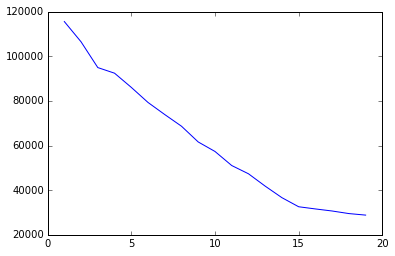

In [365]:
# looking at inertia as we change k
x = []
y = []
for n in range(1,20):
    km2 = KMeans(n_clusters=n)
    km2.fit(X_scale)
    x.append(n)
    y.append(km2.inertia_)
plt.plot(x, y)
# clear elbow at around 15

In [366]:
update_km = KMeans(n_clusters=15)
update_km.fit(X_scale)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=15, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [367]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = []
#for x in range(0,12):
#    collums= {scale.inverse_transform(km.cluster_centers_[x])}
#columns
#X_train.columns
#pd.DataFrame(columns, index=X_train.columns)    
columns = {x: scale.inverse_transform(update_km.cluster_centers_[x]) for x in range(0,15)}
pd.DataFrame(columns, index=psychicDataMatrix.columns)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
C(UserValue)[High Roller],0.000,0.034,1.000,0.000,0.015,0.018,0.070,0.000,0.020,-0.000,0.000,0.004,0.004,0.029,0.000
C(UserValue)[Lapse],0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,1.000,0.000,-0.000,-0.000,-0.000,0.000
C(UserValue)[Low Value],1.000,0.892,0.000,-0.000,0.950,0.922,0.793,1.000,0.926,-0.000,1.000,0.996,0.996,0.878,0.000
C(UserValue)[Player],-0.000,0.041,0.000,1.000,0.025,0.060,0.000,0.000,0.027,-0.000,0.000,0.000,0.000,0.058,0.000
C(UserValue)[Whale],-0.000,0.034,0.000,0.000,0.010,0.000,0.137,0.000,0.027,0.000,-0.000,0.000,0.000,0.036,1.000
C(gender)[T.FEMALE],0.979,0.858,0.990,0.901,0.791,0.838,-0.000,0.976,0.799,0.914,0.983,0.883,0.773,0.878,0.986
C(gender)[T.MALE],-0.000,0.122,-0.000,0.092,0.194,0.150,1.000,0.000,0.188,0.076,-0.000,0.114,0.206,0.101,-0.000
C(platform)[T.IOS],0.766,0.412,0.710,0.699,0.662,0.653,0.681,0.820,0.530,0.800,0.619,0.720,0.765,0.719,0.669
Average_Answer,5754.440,15913.399,9223.940,9468.965,7178.980,12795.868,8722.084,13528.450,8592.436,13537.552,8093.504,10761.568,5814.151,11095.137,10160.094
Age,25.729,27.608,29.277,28.660,26.766,27.671,27.527,25.122,27.799,31.657,26.864,25.182,27.378,25.554,30.283


In [368]:
psychicDataMatrix['segments']=update_km.labels_

In [369]:
psychicDataMatrix.segments.value_counts()

10    1363
0     1024
7      540
14     417
2      383
6      357
3      282
11     264
12     238
4      201
5      167
8      149
1      148
13     139
9      105
dtype: int64

In [370]:
psychicDataMatrix[psychicDataMatrix.segments == 9].head()

,C(UserValue)[High Roller],C(UserValue)[Lapse],C(UserValue)[Low Value],C(UserValue)[Player],C(UserValue)[Whale],C(gender)[T.FEMALE],C(gender)[T.MALE],C(platform)[T.IOS],Average_Answer,Age,...,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,segments
1225,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1101.000,32.000,...,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9
1226,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,405.000,39.000,...,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9
1227,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,484.000,24.000,...,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,9
1228,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,24372.000,44.000,...,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,9
1229,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,3652.000,19.000,...,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9


In [375]:
# So we have 15 Clusters, as you can see cluster 5 is Lapsed users while cluster 9 appears to be Whales
# Lets use RandomForestClassifier to see if we can find a good way of classifying people
data.dtypes

label_key = pd.factorize(data['UserValue'])[1]
data['labels'] = pd.factorize(data['UserValue'])[0]

In [377]:
data.tail()

,UserKey,Average_Answer,UserValue,Amber,Bethany,Cynthia,David,Desiree,Gina,Kitty,Laurie,Liz,Samantha,gender,platform,Age,labels
5772,OydmWiNDxzbBDm251UmQpEa9tBQG0cLk@talkpok.appsp...,1017,Low Value,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,32.000,4
5773,NMKUd2ZjRkk8C5FpI60oKTPuogaP1ghq@talkpok.appsp...,270,Low Value,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,MALE,IOS,18.000,4
5774,RJouF688FULJbrwQzuk0i2VZlzu8m5Vc@talkpok.appsp...,1877,Low Value,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,FEMALE,ANDROID,44.000,4
5775,sZjalFGmfo6WHKxFcrqbAVPC3vCiuxWV@talkpok.appsp...,303,Low Value,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,27.000,4
5776,XPtvETDN8U3XawFAvI3h8SpzhXRqxJ25@talkpok.appsp...,627,Low Value,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,FEMALE,IOS,34.000,4


In [403]:
# Lets make a training and test dataset
from sklearn.cross_validation import train_test_split
train, test = train_test_split(data, test_size = 0.2)


In [404]:

newY, newX_train = dmatrices('labels ~ 0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       train, return_type = 'dataframe')
newY = np.ravel(newY)


In [418]:
X_test = dmatrix('0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform)', 
                       test, return_type = 'dataframe')

In [419]:
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(newX_train, newY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [420]:
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=newX_train.columns).sort('importance')

,importance
C(gender)[BLANK],0.002
C(gender)[FEMALE],0.006
C(gender)[MALE],0.006
Liz,0.010
C(platform)[T.IOS],0.018
Bethany,0.019
Samantha,0.021
Gina,0.035
Laurie,0.036
David,0.056


In [421]:
from sklearn import cross_validation


In [422]:
rfscore = cross_validation.cross_val_score(rf, newX_train, newY, cv=3)
print rfscore.mean()

0.848301600512


In [423]:
# Not Bad lets do clustering again to see if we can improve


In [424]:

# first lets make a training and test data set
scale = StandardScaler()
xts = scale.fit(newX_train).transform(newX_train)


In [425]:
km = KMeans(n_clusters=5)
km.fit(xts)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

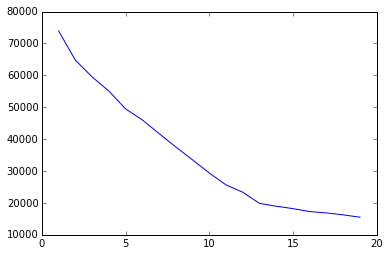

In [426]:
# looking at inertia as we change k
inertia = []
k = []
for num in range(1,20):
    km = KMeans(n_clusters=num)
    km.fit(xts)
    k.append(num)
    inertia.append(km.inertia_)
plt.plot(k, inertia)
# clear elbow at around 12 or 13

In [427]:
km = KMeans(n_clusters=12)
km.fit(xts)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=12, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [428]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
X_train.columns

columns = {x: scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,12)}
pd.DataFrame(columns, index=newX_train.columns)

,0,1,2,3,4,5,6,7,8,9,10,11
C(gender)[BLANK],-0.000,-0.000,-0.000,-0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
C(gender)[FEMALE],1.000,1.000,0.000,1.000,0.000,0.819,0.899,0.851,0.843,0.875,0.819,0.898
C(gender)[MALE],-0.000,-0.000,1.000,-0.000,-0.000,0.181,0.101,0.149,0.157,0.125,0.181,0.102
C(platform)[T.IOS],0.758,0.607,0.698,0.847,0.987,0.764,0.713,0.660,0.669,0.406,0.504,0.709
Average_Answer,5661.910,8558.280,9349.135,13143.751,7908.897,6798.397,11404.457,13011.149,6970.785,15895.898,9019.890,11094.023
Age,25.923,27.740,28.088,26.136,24.949,28.578,26.713,28.411,26.727,27.297,28.181,26.434
Amber,95.368,2.344,27.628,1.013,25.928,0.762,0.474,0.803,0.872,0.786,-0.000,0.763
Bethany,0.285,1.165,0.411,0.220,5.078,0.537,0.086,0.496,0.312,95.937,0.197,0.503
Cynthia,1.504,87.369,42.395,1.189,28.741,1.977,2.067,2.192,0.581,1.308,0.197,0.415
David,0.684,1.570,2.334,0.997,8.896,93.711,1.255,0.596,0.233,0.488,-0.000,0.519


In [429]:
trainingdata = data
train['clusters']= km.labels_

C:\Users\Vipul\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [433]:
len(km.predict(X_test))

1156

In [434]:
test['clusters'] = km.predict(X_test)

C:\Users\Vipul\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [435]:
test['clusters'].head()

4199    9
2244    1
4617    9
4697    9
808     9
Name: clusters, dtype: int32

In [436]:
newY_cl, newX_train_cl = dmatrices('labels ~ 0 + Average_Answer + Age + Amber + Bethany + Cynthia + David + Desiree + Gina + Kitty + Laurie + Liz + Samantha + C(gender) + C(platform) + C(clusters)', 
                       train, return_type = 'dataframe')
newY_cl = np.ravel(newY)

In [437]:
rf = RandomForestClassifier(max_features='sqrt')
rf.fit(newX_train_cl, newY_cl)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [438]:
rfscore_cl = cross_validation.cross_val_score(rf, newX_train_cl, newY_cl, cv=3)
print rfscore_cl.mean()

0.845054144596


In [452]:
d = {'importance': rf.feature_importances_}
pd.DataFrame(d, index=newX_train_cl.columns).sort('importance')

,importance
C(clusters)[T.10],0.000
C(clusters)[T.4],0.001
C(gender)[BLANK],0.002
C(clusters)[T.2],0.003
C(clusters)[T.6],0.003
C(clusters)[T.8],0.004
C(clusters)[T.9],0.004
C(gender)[MALE],0.005
C(clusters)[T.7],0.005
C(gender)[FEMALE],0.005


In [439]:
#clustering as a feature doesnt help but lets do PCA now
from sklearn.decomposition import RandomizedPCA

In [440]:
pca = RandomizedPCA(n_components=2)
pca.fit(xts)

RandomizedPCA(copy=True, iterated_power=3, n_components=2, random_state=None,
       whiten=False)

In [441]:
# how much variance each component explains
pca.explained_variance_ratio_

array([ 0.1249798 ,  0.09000928])

In [442]:
comp = pca.components_

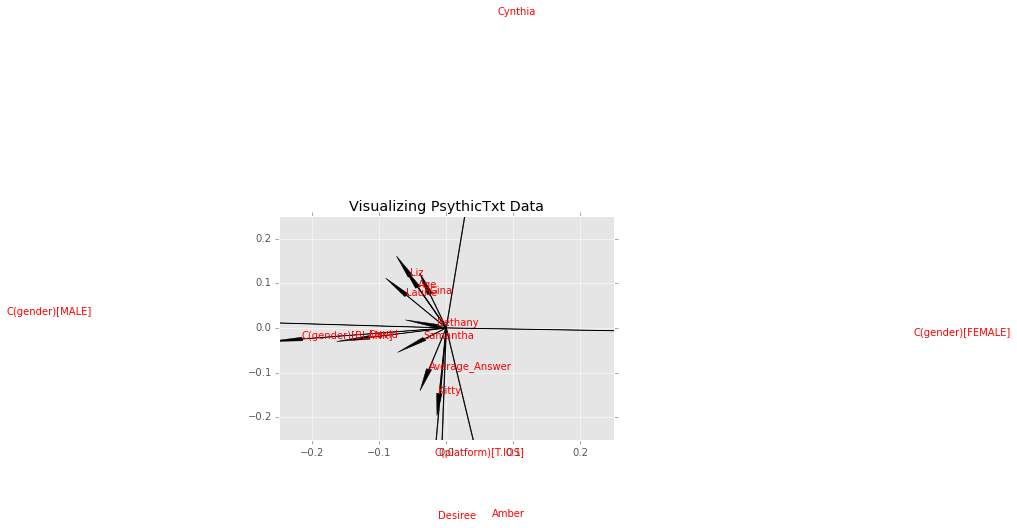

In [451]:
plt.style.use('ggplot')
plt.title('Visualizing PsythicTxt Data')
plt.xlim(-.25,.25)
plt.ylim(-.25, .25)
for index, feature in enumerate(X_train.columns):
    plt.arrow(0, 0, comp[0][index], comp[1][index], feature, color='red',
             fc="k", ec="k",head_width=0.008, head_length=0.05)
for index, feature in enumerate(X_train.columns):
    plt.text(comp[0][index], comp[1][index], feature, color='red')